## Analyze A/B Test Results 


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, you will be working to understand the results of an A/B test run by an e-commerce website. Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [4]:
unique_users = df.user_id.nunique()
unique_users

290584

d. The proportion of users converted.

In [5]:
df_unique = df.drop_duplicates(subset = ['user_id'])
unique_converted = (df_unique['converted'] == 1).mean()
unique_converted

0.11956955647936569

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
df.query('group == "treatment" & landing_page == "old_page" or group == "control" & landing_page == "new_page"')['group'].count()

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now create a new dataset that removes the rows where the group and the page do not match and store it as **df2**.

In [8]:
treatment_new = df.query('group == "treatment" & landing_page == "new_page"')
control_old = df.query('group == "control" & landing_page == "old_page"')
df2 = treatment_new.append(control_old)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [13]:
df2 = df2.drop_duplicates(subset = ['user_id'])
df2[df2['user_id'] == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the following questions.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
(df2['converted'] == 1).mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
p_old = df2.query('group == "control"').converted.mean()

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
p_new = df2.query('group == "treatment"').converted.mean()

d. What is the probability that an individual received the new page?

In [17]:
(df2['landing_page'] == 'new_page').mean()

0.50006194422266881

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Since the probability of reaching both pages is practically the same and the difference in converted users differs by less than 0.2 per cent, even in favour of the old design, there is no practical evidence that the new page design provides more conversions.**

<a id='ab_test'></a>
### Part II - A/B Test

`1.` Consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**$H_{0}$: $p_{old}$ - $p_{new}$ >= 0**

**$H_{1}$: $p_{old}$ - $p_{new}$ < 0**

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
pnew = df2['converted'].mean()
pnew

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
pold = pnew
pold

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = df2[df2['group'] == 'control'].shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(n_new, p_new)/n_new
new_page_converted

0.1194756038813571

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(n_old, p_old)/n_old
old_page_converted

0.12048955766344975

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted - old_page_converted

-0.0010139537820926525

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
new_page_converted = np.random.binomial(n_new, pnew, 10000)/n_new
old_page_converted = np.random.binomial(n_old, pold, 10000)/n_old
p_diffs = np.array(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

In [26]:
#Observed difference in conversion rate between groups
obs_diffs = p_new - p_old
obs_diffs

-0.0015782389853555567

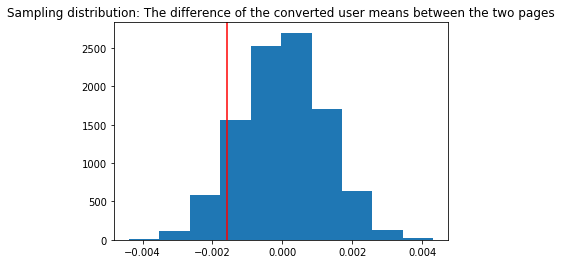

In [27]:
plt.hist(p_diffs)
plt.title('Sampling distribution: The difference of the converted user means between the two pages')
plt.axvline(x = obs_diffs, c = 'red');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [28]:
(p_diffs > obs_diffs).mean()

0.90249999999999997

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The value calculated above is the probability of observing  that the conversion rate of the new page is higher, or at least the same, than the one of the old page being the null hypothesis true.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [29]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1')['converted'].count()
convert_new = df2.query('landing_page == "new_page" & converted == 1')['converted'].count()
n_old = df2[df2['landing_page'] == 'old_page'].shape[0]
n_new = df2[df2['landing_page'] == 'new_page'].shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [30]:
zstat, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print("z-stat:", zstat)
print("p-value:", p_value)

z-stat: 1.31092419842
p-value: 0.905058312759


In [31]:
alpha_error = 0.05
z_critical = norm.ppf(1-(alpha_error/2))
z_critical

1.959963984540054

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The null hypothesis cannot be rejected since the p-value is greater than the type 1 error rate (0.905> 0.05). Regarding the z-score, its value is within the range imposed by the critical z-value (-1.95 < 1.31 <1.95), so it agrees with the calculation of the p-value**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since group and landing_page are categorical variables, a logistic regression will be used**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.

In [32]:
df2[['control', 'ab_page']] = pd.get_dummies(df2['group'])
df2['intercept'] = 1
df2.drop(['control'], axis=1, inplace=True)
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [33]:
import statsmodels.api as sm

log_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [34]:
#To use the function summary it is necessary to import chisqprob
#from scipy import stats
#stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-17 14:22 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br> 

**The p-value of the logistic regression is 0.1899 and since this value is higher than the type 1 error rate, the null hypothesis cannot be rejected.**

**The value calculated in the above section differs from the p-value calculated in Part II because the proposed hypotheses are different. While in Part II the null hypothesis was that the conversion rate of the old page was equal or better than the new page, in this section it is proposed as null hypothesis that both conversion rates are equal and therefore, the alternative hypothesis would indicate that the conversion rates are different.**

**$H_{0}$: $p_{old}$ = $p_{new}$**

**$H_{1}$: $p_{old}$ $\neq$ $p_{new}$**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Since the p-value is too high to be statistically significant, it would be useful to explore other variables that could influence the conversion such as gender, age, time or location, among others. Additionally, the insertion of new variables could have a positive impact on the model if the R-squared value is increased, since a high value of this term is generally related to a good prediction of the model.**

**The disadvantage of adding more variables to the model could be the lack of linearity with the response variable or multicollinearity among the predictors.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

In [35]:
#Read the countries file
country = pd.read_csv('countries.csv')
country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
#Inner join between both dataframes, df2 and country
df_country = df2.set_index('user_id').join(country.set_index('user_id'), how = 'inner')
df_country.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country
user_id,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [37]:
df_country.country.unique()

array(['US', 'CA', 'UK'], dtype=object)

In [38]:
#Create dummie variables for each country
df_country[['CA', 'UK', 'US']] = pd.get_dummies(df_country['country'])
df_country.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,CA,UK,US
user_id,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,1,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,0,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,1,0,0


In [39]:
#Fit a logistic regression model
log_country = sm.Logit(df_country['converted'], df_country[['intercept','ab_page', 'CA', 'UK']])
results_country = log_country.fit()
results_country.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-17 14:22 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

**Similar to the previous sections, all p-values are too high to be statistically significant, so it cannot be concluded that the country or the design of the page influences the conversion of users. Also, the R-squared has not increased, which suggests that this model is not very good at predicting response.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [40]:
# Creation of interactions between ab_page and country
df_country['int_CA'] = df_country['ab_page'] * df_country['CA']
df_country['int_UK'] = df_country['ab_page'] * df_country['UK']

#Fit a logistic regression model
log_country_int = sm.Logit(df_country['converted'], df_country[['intercept', 'CA', 'UK', 'int_CA', 'int_UK', ]])
results_country_int = log_country_int.fit()
results_country_int.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-17 14:22 AIC:              212782.9259
No. Observations:   290584           BIC:              212835.8241
Df Model:           4                Log-Likelihood:   -1.0639e+05
Df Residuals:       290579           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9967    0.0068  -292.3145  0.0000  -2.0101  -1.9833
CA           -0.0073    0.0371    -0.1963  0.8444  -0.0799   0.0654
UK            0.0045    0.0175     0.2572  0.7970  -0.0298   0.0389
int_CA       -0.0674    0.0520    -1.2967  0.1947  -0.1694   0.0345
int_UK        0.0108    0.0228     0.4749  0.6349  -0.0339   0.0555
==================================================================

"""

**Again, all p-values are too high to conclude that they are significant in predicting user conversion. Furthermore, no increase in R-squared is observed that suggests an improvement in prediction.**

i. To finish, evaluate if the timestamp column generates any valuable information.

In [41]:
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


In [42]:
#Change 'timestamp' from obj to int64 and describe it
df2['timestamp'] = pd.to_datetime(df2['timestamp'])
df2['timestamp'].describe()

count                         290584
unique                        290584
top       2017-01-06 05:19:03.372027
freq                               1
first     2017-01-02 13:42:05.378582
last      2017-01-24 13:41:54.460509
Name: timestamp, dtype: object

In [43]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 2 to 294476
Data columns (total 7 columns):
user_id         290584 non-null int64
timestamp       290584 non-null datetime64[ns]
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
ab_page         290584 non-null uint8
intercept       290584 non-null int64
dtypes: datetime64[ns](1), int64(3), object(2), uint8(1)
memory usage: 15.8+ MB


In [44]:
#Create a column that differenciates the days of the week
df2['day_of_week'] = df2['timestamp'].dt.dayofweek

#Convert days of week to weekdays or weekends
df2['weekday'] = np.where((df2['day_of_week']) < 5, 0, 1)

# Create the border between parts of the day
afternoon = pd.to_datetime('12:00:00').time()

# create column where value is 1 if the transaction is done after 1200hrs, else it is 0.
df2['daytime'] = np.where((df2['timestamp'].dt.time) < afternoon, 0, 1)

df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept,day_of_week,weekday,daytime
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,2,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,6,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,3,0,0
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,2,0,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,6,1,1


In [45]:
#Fit a logistic regression model
log_day = sm.Logit(df2['converted'], df2[['intercept', 'daytime', 'weekday']])
results_day = log_day.fit()
results_day.summary2()

Optimization terminated successfully.
         Current function value: 0.366114
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-09-17 14:22 AIC:              212779.8391
No. Observations:   290584           BIC:              212811.5781
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -2.0082    0.0088  -227.0488  0.0000  -2.0256  -1.9909
daytime       0.0235    0.0114     2.0559  0.0398   0.0011   0.0459
weekday       0.0006    0.0128     0.0456  0.9636  -0.0245   0.0257
==================================================================

"""

In [46]:
np.exp(0.0235)

1.0237783007466292

- **The above analysis indicates that the type of day, weekend or weekday, is not a good predictor of user conversions, however, the p-value associated with the time when the transaction has been done is lower than the rate of type one errors, so this variable is significant. In this case, it is possible to reject the null hypothesis and assume that if a user accesses the page after mid-day, it would have 2.37% more probabilities of being converted.**


- **To conlude, the experiment has only been carried out between January 2nd and 24th so the data may be affected by biases such as novelty effect or change aversion. Therefore, it seems that the best decision would be to run the experiment for a longer period of time.**

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])